Expected Loss

Original Target distribution for 48-month horizon (PD):
Default_48m
0    1464285
1      83993
Name: count, dtype: int64

Balanced dataset shape for PD model training: (167986, 45)
Default_48m
1    83993
0    83993
Name: count, dtype: int64

Dataset shape for LGD model training (only defaulted loans): (83993, 45)
count    83993.000000
mean         0.857247
std          0.177532
min          0.000000
25%          0.794764
50%          0.920913
75%          0.988322
max          1.000000
Name: LGD, dtype: float64

--- Training PD Model (XGBoost Classifier) ---

--- XGBoost Classifier (PD) Test Results (48-month Horizon) ---
AUC: 0.9738
Classification Report (Threshold 0.90):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    292857
           1       0.66      0.66      0.66     16799

    accuracy                           0.96    309656
   macro avg       0.82      0.82      0.82    309656
weighted avg       0.96      0.96      0.96    

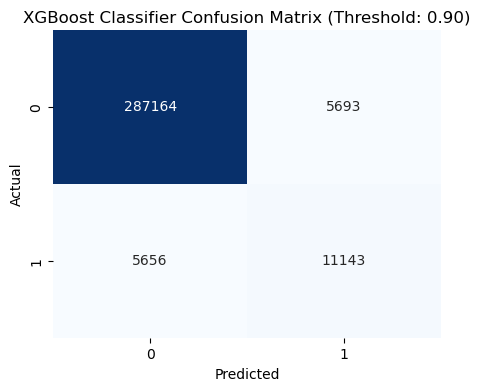


XGBoost Classifier (PD) Cross-Validation Metrics (5-fold)
Mean AUC: 0.9718
Mean F1:  0.9198
Mean Acc: 0.9178

--- Training LGD Model (XGBoost Regressor) ---

--- XGBoost Regressor (LGD) Test Results ---
RMSE: 0.1518
MAE:  0.0994
R^2:  0.2808


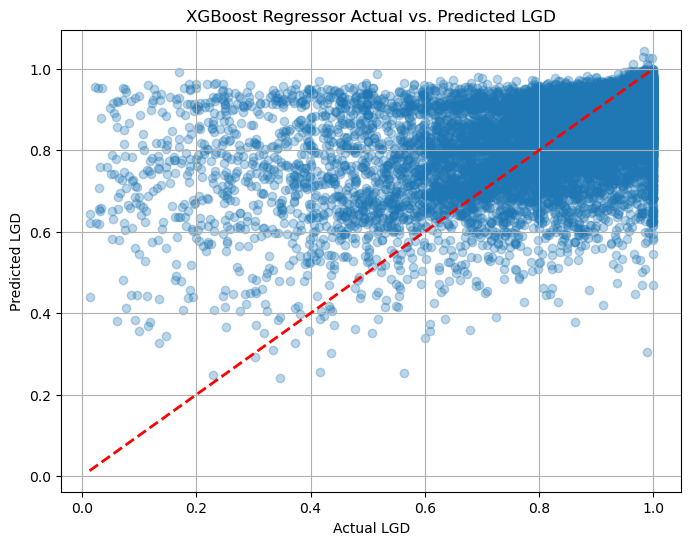


XGBoost Regressor (LGD) Cross-Validation Metrics (5-fold)
Mean RMSE: 0.1493
Mean MAE:  0.0983
Mean R2:   0.2894

--- Calculating Expected Loss (EL) ---

Sample of Expected Loss results per loan (Test Set):
         Predicted_PD_Proba  Predicted_PD_Binary  Predicted_LGD       EAD  \
1249976            0.963190                    1       0.869939   10000.0   
477545             0.013272                    0       0.916377   35000.0   
1410228            0.938590                    1       0.925498   15000.0   
974126             0.007199                    0       0.905087   50000.0   
149537             0.097229                    0       0.882468  250000.0   
430910             0.878756                    0       0.867004  150000.0   
1410045            0.033154                    0       0.800013  126500.0   
471205             0.717817                    0       0.539493  130500.0   
163515             0.000297                    0       0.532844  625000.0   
268243             0.00

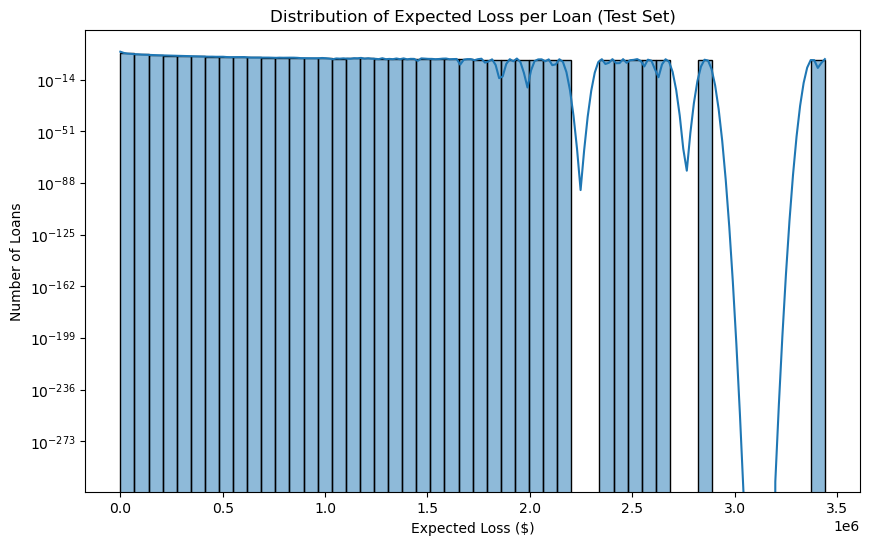


--- Cross-Validation Metrics Summary ---

PD Model Metrics:
                         AUC        F1  Accuracy
XGBoost Classifier  0.971838  0.919756  0.917809

LGD Model Metrics:
                       RMSE       MAE        R2
XGBoost Regressor  0.149341  0.098328  0.289422

--- PD Model Evaluation at Chosen Threshold (0.90) ---

--- XGBoost Classifier (PD) Test Results with Threshold: 0.90 ---
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    292857
           1       0.66      0.66      0.66     16799

    accuracy                           0.96    309656
   macro avg       0.82      0.82      0.82    309656
weighted avg       0.96      0.96      0.96    309656

Confusion Matrix:
[[287164   5693]
 [  5656  11143]]


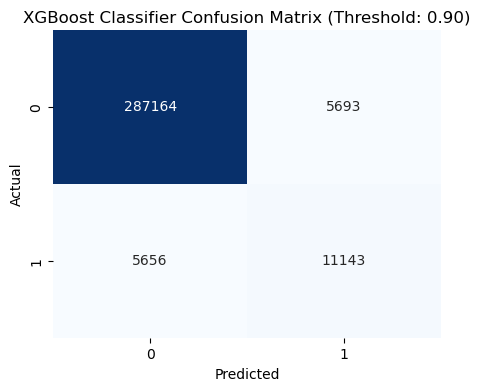

False Positives (FP): 5693
False Negatives (FN): 5656
Precision (Class 1): 0.6619
Recall (Class 1): 0.6633


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, # Regression metrics
    classification_report, roc_auc_score, confusion_matrix # Classification metrics
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor

# Configuration 
H = 48  # Horizon in months for default prediction
PD_THRESHOLD = 0.90 # Chosen default threshold for PD model for reporting and binary decisions

df = pd.read_csv('/Users/caitlyndinh/ai-academy/FinalProject/merged_with_naics.csv', low_memory=False)

# Prepare Target Variables (PD and LGD)

# Ensure date columns are datetime
df['ApprovalDate'] = pd.to_datetime(df['ApprovalDate'], errors='coerce')
df['ChargeOffDate'] = pd.to_datetime(df['ChargeOffDate'], errors='coerce')

# Calculate months to default
months_to_default = (df['ChargeOffDate'] - df['ApprovalDate']).dt.days / 30.4375

# PD Target: Default_48m (1 if default within H months, 0 otherwise)
df[f'Default_{H}m'] = ((~months_to_default.isna()) & (months_to_default <= H)).astype(int)

# Drop rows where target is NaN (if any)
df = df.dropna(subset=[f'Default_{H}m'])

print(f"Original Target distribution for {H}-month horizon (PD):")
print(df[f'Default_{H}m'].value_counts())

# Convert relevant columns to numeric for LGD calculation
df['GrossChargeOffAmount'] = pd.to_numeric(df['GrossChargeOffAmount'], errors='coerce').fillna(0)
df['GrossApproval'] = pd.to_numeric(df['GrossApproval'], errors='coerce').fillna(0) # Fill 0 for safety

# LGD Target: Loss Given Default (ChargeOffAmount / GrossApproval)
df['LGD'] = np.where(
    (df[f'Default_{H}m'] == 1) & (df['GrossApproval'] > 0), # Only for actual defaults and valid approval
    df['GrossChargeOffAmount'] / df['GrossApproval'],
    np.nan 
)

# Clamp LGD values between 0 and 1
df['LGD'] = np.clip(df['LGD'], 0, 1)

# Data Balancing for PD Model Training (Undersampling)

defaults_pd = df[df[f'Default_{H}m'] == 1].copy()
non_defaults_pd = df[df[f'Default_{H}m'] == 0].copy()

# Determine the size of the minority class for PD balancing
minority_class_size_pd = len(defaults_pd)

if len(non_defaults_pd) > minority_class_size_pd:
    non_defaults_sample_pd = non_defaults_pd.sample(n=minority_class_size_pd, random_state=42)
    defaults_sample_pd = defaults_pd # Take all defaults
else:
    # This case is rare, but handles if non_defaults are fewer than defaults
    majority_class_size_pd = len(non_defaults_pd)
    defaults_sample_pd = defaults_pd.sample(n=majority_class_size_pd, random_state=42)
    non_defaults_sample_pd = non_defaults_pd

df_balanced_pd = pd.concat([defaults_sample_pd, non_defaults_sample_pd])

print(f"\nBalanced dataset shape for PD model training: {df_balanced_pd.shape}")
print(df_balanced_pd[f'Default_{H}m'].value_counts())

# Filter for LGD Model Training (Only defaulted loans)

df_lgd_train = df[df['LGD'].notna()].copy()

print(f"\nDataset shape for LGD model training (only defaulted loans): {df_lgd_train.shape}")
print(df_lgd_train['LGD'].describe())

# Remove leakage columns
leakage_cols = ['ChargeOffDate', 'GrossChargeOffAmount', 'PaidInFullDate', 'LoanStatus', 'FirstDisbursementDate']
# Apply removal to both the full df and the LGD-specific df
df = df.drop(columns=[col for col in leakage_cols if col in df.columns])
df_balanced_pd = df_balanced_pd.drop(columns=[col for col in leakage_cols if col in df_balanced_pd.columns])
df_lgd_train = df_lgd_train.drop(columns=[col for col in leakage_cols if col in df_lgd_train.columns])


# Feature Engineering (Common for PD and LGD)
features = [
    'Program', 'Subprogram', 'GrossApproval', 'SBAGuaranteedApproval', 'ApprovalDate',
    'InitialInterestRate', 'FixedOrVariableInterestInd', 'TermInMonths',
    'BusinessType', 'BusinessAge', 'CollateralInd', 'RevolverStatus', 'JobsSupported', 'ProjectState'
]

# Process ApprovalDate for all relevant dataframes and add derived features
for temp_df in [df, df_balanced_pd, df_lgd_train]:
    if 'ApprovalDate' in temp_df.columns:
        temp_df['ApprovalDate'] = pd.to_datetime(temp_df['ApprovalDate'], errors='coerce')
        temp_df['ApprovalYear'] = temp_df['ApprovalDate'].dt.year
        temp_df['ApprovalMonth'] = temp_df['ApprovalDate'].dt.month
        temp_df.drop(columns=['ApprovalDate'], inplace=True)

# Update features list to include derived date features and exclude original 'ApprovalDate'
features_final = [f for f in features if f != 'ApprovalDate']
features_final.extend(['ApprovalYear', 'ApprovalMonth'])


numeric_features = ['GrossApproval', 'SBAGuaranteedApproval', 'InitialInterestRate',
                    'TermInMonths', 'JobsSupported', 'ApprovalYear', 'ApprovalMonth']

# Ensure categorical_features correctly reflects the updated features list
categorical_features = [col for col in features_final if col not in numeric_features]

# Preprocessing Pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Train / Test Split for PD and LGD

X_full = df[features_final].copy() # Use features_final here
y_pd_full = df[f'Default_{H}m'] # PD target for the entire dataset
y_lgd_full = df['LGD'] # LGD target (will have NaNs for non-defaults)

# Split the full dataset, stratifying by PD target
X_train_full, X_test_full, y_train_pd_full, y_test_pd_full, y_train_lgd_full, y_test_lgd_full = \
    train_test_split(X_full, y_pd_full, y_lgd_full, stratify=y_pd_full, test_size=0.2, random_state=42)

# Prepare training data for PD model (using balanced data)
X_train_pd_raw = df_balanced_pd[features_final].copy() # Use features_final here
y_train_pd = df_balanced_pd[f'Default_{H}m']

# Prepare training data for LGD model (using only defaulted loans from the training split)
X_train_lgd_raw = X_train_full[y_train_lgd_full.notna()].copy()
y_train_lgd = y_train_lgd_full[y_train_lgd_full.notna()]


preprocessor.fit(X_train_full)

# Now, transform all datasets using the *fitted* preprocessor
X_train_pd_transformed = preprocessor.transform(X_train_pd_raw)
X_train_lgd_transformed = preprocessor.transform(X_train_lgd_raw)
X_test_full_transformed = preprocessor.transform(X_test_full)
# Also transform the actual LGD test set for plotting/evaluation
X_test_lgd_actual_raw = X_test_full[y_test_lgd_full.notna()].copy()
X_test_lgd_actual_transformed = preprocessor.transform(X_test_lgd_actual_raw)


# Helper Functions (Adapted for PD and LGD)
metrics_dict_pd = {}
metrics_dict_lgd = {}
cv_pd = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # For PD
cv_lgd = KFold(n_splits=5, shuffle=True, random_state=42) # For LGD

def plot_confusion_matrix(cm, model_name, threshold=0.5):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name} Confusion Matrix (Threshold: {threshold:.2f})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def plot_actual_vs_predicted(y_true, y_pred, model_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2) # Diagonal line for perfect prediction
    plt.xlabel('Actual LGD')
    plt.ylabel('Predicted LGD')
    plt.title(f'{model_name} Actual vs. Predicted LGD')
    plt.grid(True)
    plt.show()

# PD Model Training and Evaluation 
def train_and_evaluate_pd(model, model_name):
    clf = Pipeline(steps=[('classifier', model)])
    clf.fit(X_train_pd_transformed, y_train_pd) # Train on balanced PD data (transformed)

    y_proba = clf.predict_proba(X_test_full_transformed)[:, 1]
    auc = roc_auc_score(y_test_pd_full, y_proba)

    print(f"\n--- {model_name} (PD) Test Results ({H}-month Horizon) ---")
    print("=" * 60)
    print(f"AUC: {auc:.4f}")

    # Evaluate with the chosen PD_THRESHOLD
    y_pred_threshold = (y_proba >= PD_THRESHOLD).astype(int)
    print(f"Classification Report (Threshold {PD_THRESHOLD:.2f}):")
    print(classification_report(y_test_pd_full, y_pred_threshold))
    cm_threshold = confusion_matrix(y_test_pd_full, y_pred_threshold)
    print(f"Confusion Matrix (Threshold {PD_THRESHOLD:.2f}):")
    print(cm_threshold)
    plot_confusion_matrix(cm_threshold, model_name, threshold=PD_THRESHOLD)

    # Cross-validation for PD model (using pre-transformed data for cross_validate)
    temp_clf_cv = Pipeline(steps=[('classifier', model)])
    scoring = ['roc_auc', 'f1', 'accuracy']
    scores = cross_validate(temp_clf_cv, X_train_pd_transformed, y_train_pd, cv=cv_pd, scoring=scoring, n_jobs=-1)
    metrics_dict_pd[model_name] = {
        'AUC': scores['test_roc_auc'].mean(),
        'F1': scores['test_f1'].mean(),
        'Accuracy': scores['test_accuracy'].mean()
    }
    print(f"\n{model_name} (PD) Cross-Validation Metrics (5-fold)")
    print("=" * 55)
    print(f"Mean AUC: {metrics_dict_pd[model_name]['AUC']:.4f}")
    print(f"Mean F1:  {metrics_dict_pd[model_name]['F1']:.4f}")
    print(f"Mean Acc: {metrics_dict_pd[model_name]['Accuracy']:.4f}")

    return clf # Return the trained PD pipeline


#  LGD Model Training and Evaluation 
def train_and_evaluate_lgd(model, model_name):
    reg = Pipeline(steps=[('regressor', model)])
    reg.fit(X_train_lgd_transformed, y_train_lgd) # Train only on defaulted loans (transformed)

    # Evaluate on the test set, but only where LGD is available (i.e., actual defaults)
    y_pred_lgd = reg.predict(X_test_lgd_actual_transformed) # Predict on transformed data

    rmse = np.sqrt(mean_squared_error(y_test_lgd_full[y_test_lgd_full.notna()], y_pred_lgd))
    mae = mean_absolute_error(y_test_lgd_full[y_test_lgd_full.notna()], y_pred_lgd)
    r2 = r2_score(y_test_lgd_full[y_test_lgd_full.notna()], y_pred_lgd)

    print(f"\n--- {model_name} (LGD) Test Results ---")
    print("=" * 50)
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R^2:  {r2:.4f}")
    plot_actual_vs_predicted(y_test_lgd_full[y_test_lgd_full.notna()], y_pred_lgd, model_name)

    # Cross-validation for LGD model (using pre-transformed data for cross_validate)
    temp_reg_cv = Pipeline(steps=[('regressor', model)])
    scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']
    scores = cross_validate(temp_reg_cv, X_train_lgd_transformed, y_train_lgd, cv=cv_lgd, scoring=scoring, n_jobs=-1)
    metrics_dict_lgd[model_name] = {
        'RMSE': np.sqrt(-scores['test_neg_mean_squared_error']).mean(),
        'MAE': -scores['test_neg_mean_absolute_error'].mean(),
        'R2': scores['test_r2'].mean()
    }
    print(f"\n{model_name} (LGD) Cross-Validation Metrics (5-fold)")
    print("=" * 55)
    print(f"Mean RMSE: {metrics_dict_lgd[model_name]['RMSE']:.4f}")
    print(f"Mean MAE:  {metrics_dict_lgd[model_name]['MAE']:.4f}")
    print(f"Mean R2:   {metrics_dict_lgd[model_name]['R2']:.4f}")

    return reg # Return the trained LGD pipeline

# New Function to Evaluate PD with Custom Threshold 
def evaluate_pd_with_threshold(pd_pipeline, model_name, threshold, y_true, X_transformed):
    y_proba = pd_pipeline.predict_proba(X_transformed)[:, 1]
    y_pred_threshold = (y_proba >= threshold).astype(int)

    print(f"\n--- {model_name} (PD) Test Results with Threshold: {threshold:.2f} ---")
    print("=" * 70)
    print(classification_report(y_true, y_pred_threshold))
    cm = confusion_matrix(y_true, y_pred_threshold)
    print("Confusion Matrix:")
    print(cm)
    plot_confusion_matrix(cm, model_name, threshold=threshold)
    # You can also print specific metrics like false positives:
    tn, fp, fn, tp = cm.ravel()
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"Precision (Class 1): {tp / (tp + fp):.4f}")
    print(f"Recall (Class 1): {tp / (tp + fn):.4f}")


# Train & Evaluate PD and LGD Models
print("\n--- Training PD Model (XGBoost Classifier) ---")
pd_model_pipeline = train_and_evaluate_pd(XGBClassifier(n_estimators=75, eval_metric='logloss', random_state=42, n_jobs=-1), "XGBoost Classifier")

print("\n--- Training LGD Model (XGBoost Regressor) ---")
lgd_model_pipeline = train_and_evaluate_lgd(XGBRegressor(n_estimators=75, objective='reg:squarederror', random_state=42, n_jobs=-1), "XGBoost Regressor")


# Expected Loss (EL) Calculation
print("\n--- Calculating Expected Loss (EL) ---")

# 1. Predict PD for the entire test set
predicted_pd_proba = pd_model_pipeline.predict_proba(X_test_full_transformed)[:, 1]
# Apply the chosen threshold (0.80) for binary PD prediction in EL calculation
predicted_pd_binary = (predicted_pd_proba >= PD_THRESHOLD).astype(int)


# 2. Predict LGD for the entire test set
predicted_lgd = lgd_model_pipeline.predict(X_test_full_transformed)

# 3. Define EAD (Exposure at Default)
ead = X_test_full['GrossApproval'].fillna(0).values # Convert to numpy array for element-wise multiplication

# 4. Calculate Expected Loss (EL) for each loan in the test set
expected_loss_per_loan = predicted_pd_proba * predicted_lgd * ead

# Add EL to a DataFrame for easier inspection
el_results_df = X_test_full.copy() # Keep original X_test_full for its columns
el_results_df['Actual_PD'] = y_test_pd_full
el_results_df['Actual_LGD'] = y_test_lgd_full # Will have NaNs for non-defaults
el_results_df['Predicted_PD_Proba'] = predicted_pd_proba # Store probability
el_results_df['Predicted_PD_Binary'] = predicted_pd_binary # Store binary prediction at chosen threshold
el_results_df['Predicted_LGD'] = predicted_lgd
el_results_df['EAD'] = ead
el_results_df['Expected_Loss'] = expected_loss_per_loan

print("\nSample of Expected Loss results per loan (Test Set):")
print(el_results_df[['Predicted_PD_Proba', 'Predicted_PD_Binary', 'Predicted_LGD', 'EAD', 'Expected_Loss', 'Actual_PD', 'Actual_LGD']].head(10))

# 5. Aggregate Portfolio-Level Expected Loss
portfolio_expected_loss = el_results_df['Expected_Loss'].sum()
print(f"\nTotal Portfolio Expected Loss (Test Set): ${portfolio_expected_loss:,.2f}")

# You can also calculate average Expected Loss per loan
average_expected_loss_per_loan = el_results_df['Expected_Loss'].mean()
print(f"Average Expected Loss per loan (Test Set): ${average_expected_loss_per_loan:,.2f}")

# Optional: Visualize Expected Loss Distribution
plt.figure(figsize=(10, 6))
sns.histplot(el_results_df['Expected_Loss'], bins=50, kde=True)
plt.title('Distribution of Expected Loss per Loan (Test Set)')
plt.xlabel('Expected Loss ($)')
plt.ylabel('Number of Loans')
plt.yscale('log') # Often useful for skewed distributions
plt.show()

# Optional: Compare CV metrics for PD and LGD models
print("\n--- Cross-Validation Metrics Summary ---")
print("\nPD Model Metrics:")
print(pd.DataFrame(metrics_dict_pd).T)
print("\nLGD Model Metrics:")
print(pd.DataFrame(metrics_dict_lgd).T)

# PD Model Evaluation at Chosen Threshold (for reporting/analysis)
print(f"\n--- PD Model Evaluation at Chosen Threshold ({PD_THRESHOLD:.2f}) ---")
evaluate_pd_with_threshold(pd_model_pipeline, "XGBoost Classifier", PD_THRESHOLD, y_test_pd_full, X_test_full_transformed)



--- Expected Loss Summary for Outstanding Loans (LoanStatus == 'EXEMPT') ---
Total Expected Loss: $2,943,185,745.75
Average Expected Loss per Loan: $10,487.82
Annualized Expected Loss (approx.): $735,796,436.44


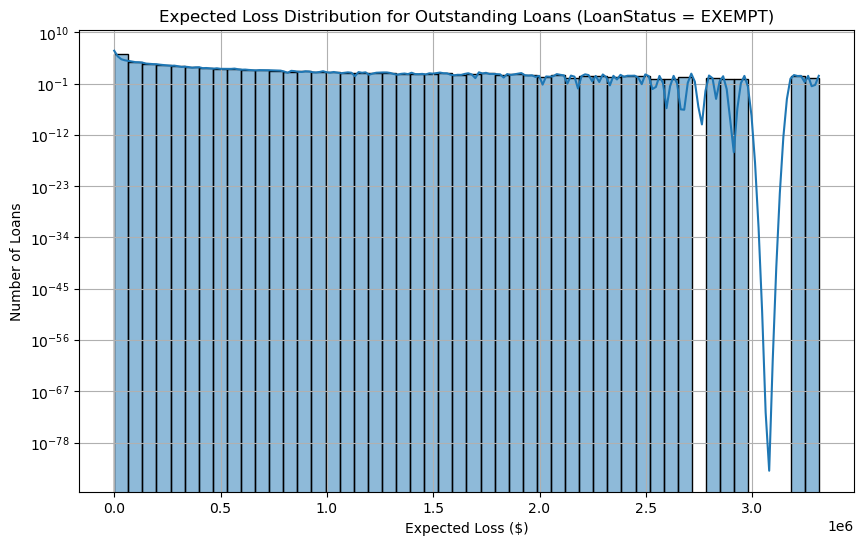


Expected Loss by Year:
  Year  Expected_Loss
Year 1   7.357964e+08
Year 2   7.357964e+08
Year 3   7.357964e+08
Year 4   7.357964e+08


In [33]:
# --- Predict Expected Loss for Outstanding Loans (LoanStatus == 'EXEMPT') ---

# NOTE: Use the original DataFrame before filtering/dropping rows (save this early on if not already):
df_original = pd.read_csv('/Users/caitlyndinh/ai-academy/FinalProject/merged_with_naics.csv', low_memory=False)

# Ensure consistent types
df_original['ApprovalDate'] = pd.to_datetime(df_original['ApprovalDate'], errors='coerce')
df_original['GrossApproval'] = pd.to_numeric(df_original['GrossApproval'], errors='coerce').fillna(0)

# 1. Filter for outstanding loans
df_outstanding = df_original[df_original['LoanStatus'] == 'EXEMPT'].copy()

# 2. Create date-based features (ApprovalYear, ApprovalMonth)
df_outstanding['ApprovalYear'] = df_outstanding['ApprovalDate'].dt.year
df_outstanding['ApprovalMonth'] = df_outstanding['ApprovalDate'].dt.month
df_outstanding.drop(columns=['ApprovalDate'], inplace=True, errors='ignore')

# 3. Make sure other required features are present and consistent
# (Recreate or recast if necessary)
for col in features_final:
    if col not in df_outstanding.columns:
        df_outstanding[col] = np.nan  # Fill missing required features with NaN

# 4. Extract and transform features
X_outstanding = df_outstanding[features_final].copy()
X_outstanding_transformed = preprocessor.transform(X_outstanding)

# 5. Predict PD probabilities
predicted_pd_proba_outstanding = pd_model_pipeline.predict_proba(X_outstanding_transformed)[:, 1]

# 6. Predict LGD values
predicted_lgd_outstanding = lgd_model_pipeline.predict(X_outstanding_transformed)

# 7. Define Exposure at Default (EAD)
ead_outstanding = df_outstanding['GrossApproval'].values

# 8. Calculate Expected Loss (EL) = PD * LGD * EAD
expected_loss_outstanding = predicted_pd_proba_outstanding * predicted_lgd_outstanding * ead_outstanding

# 9. Store results in DataFrame
df_outstanding['Predicted_PD_Proba'] = predicted_pd_proba_outstanding
df_outstanding['Predicted_LGD'] = predicted_lgd_outstanding
df_outstanding['EAD'] = ead_outstanding
df_outstanding['Expected_Loss'] = expected_loss_outstanding

# 10. Portfolio-level summary stats
portfolio_expected_loss_outstanding = df_outstanding['Expected_Loss'].sum()
average_expected_loss_outstanding = df_outstanding['Expected_Loss'].mean()

print(f"\n--- Expected Loss Summary for Outstanding Loans (LoanStatus == 'EXEMPT') ---")
print(f"Total Expected Loss: ${portfolio_expected_loss_outstanding:,.2f}")
print(f"Average Expected Loss per Loan: ${average_expected_loss_outstanding:,.2f}")

annual_expected_loss = portfolio_expected_loss_outstanding / 4
print(f"Annualized Expected Loss (approx.): ${annual_expected_loss:,.2f}")


# 11. Visualize Expected Loss Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_outstanding['Expected_Loss'], bins=50, kde=True)
plt.title('Expected Loss Distribution for Outstanding Loans (LoanStatus = EXEMPT)')
plt.xlabel('Expected Loss ($)')
plt.ylabel('Number of Loans')
plt.yscale('log')
plt.grid(True)
plt.show()

# Assume you've already computed the following:
# df_outstanding['Expected_Loss'] – cumulative EL per loan
# df_outstanding['Predicted_PD_Proba']
# df_outstanding['Predicted_LGD']
# df_outstanding['EAD']

# 1. Divide cumulative 48-month PD into 4 equal yearly increments
years = 4
monthly_pd = df_outstanding['Predicted_PD_Proba'] / 48
yearly_pd_probs = pd.DataFrame({
    f'Year_{i+1}_PD': monthly_pd * 12 for i in range(years)
})

# 2. Compute expected loss for each year
# EL_year_i = PD_i * LGD * EAD
for i in range(1, years + 1):
    df_outstanding[f'EL_Year_{i}'] = (
        yearly_pd_probs[f'Year_{i}_PD'] *
        df_outstanding['Predicted_LGD'] *
        df_outstanding['EAD']
    )

# 3. Aggregate total expected loss by year
yearly_el = df_outstanding[[f'EL_Year_{i}' for i in range(1, years + 1)]].sum()

# 5. Print table summary
yearly_el_df = pd.DataFrame({
    'Year': [f'Year {i}' for i in range(1, 5)],
    'Expected_Loss': yearly_el.values
})
print("\nExpected Loss by Year:")
print(yearly_el_df.to_string(index=False))



Projected Fee

In [34]:
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta

# --- Configuration ---
PROJECTION_MONTHS = 48

# --- Load Data ---
df = pd.read_csv('/Users/caitlyndinh/ai-academy/FinalProject/merged_with_naics.csv',
                 parse_dates=['ApprovalDate', 'AsOfDate', 'FirstDisbursementDate'], low_memory=False)

# --- Filter current outstanding loans ---
df['LoanStatus'] = df['LoanStatus'].astype(str).str.strip().str.upper()
df = df[df['LoanStatus'] == 'EXEMPT'].copy()
total_loans = len(df)

# --- Required columns for calculations ---
required_cols = ['GrossApproval', 'SBAGuaranteedApproval', 'ApprovalDate', 'AsOfDate', 'TermInMonths', 'InitialInterestRate', 'FirstDisbursementDate']
missing_counts = df[required_cols].isna().sum()
num_missing_loans = df[required_cols].isnull().any(axis=1).sum()

# --- Fill missing interest rates using FY averages ---
def get_fiscal_year(date):
    return date.year + 1 if date.month >= 10 else date.year

df['FiscalYear'] = df['ApprovalDate'].apply(get_fiscal_year)
initial_missing_rate_count = df['InitialInterestRate'].isna().sum()
fy_avg_interest = df.groupby('FiscalYear')['InitialInterestRate'].mean()
overall_avg_rate = df['InitialInterestRate'].mean()
fy_fill_count = 0
fallback_fill_count = 0

def fill_missing_rate(row):
    global fy_fill_count, fallback_fill_count 
    if pd.isnull(row['InitialInterestRate']):
        fy_avg = fy_avg_interest.get(row['FiscalYear'], np.nan)
        if not pd.isnull(fy_avg):
            fy_fill_count += 1
            return fy_avg
        else:
            fallback_fill_count += 1
            return overall_avg_rate
    return row['InitialInterestRate']

df['InitialInterestRate'] = df.apply(fill_missing_rate, axis=1)
final_missing_rate_count = df['InitialInterestRate'].isna().sum()
filled_total = initial_missing_rate_count - final_missing_rate_count

# --- Drop rows with remaining missing data ---
df = df.dropna(subset=required_cols).copy()
cleaned_loans = len(df)

# --- Calculate months elapsed since disbursement ---
def calculate_months_elapsed(row):
    if pd.isnull(row['AsOfDate']) or pd.isnull(row['FirstDisbursementDate']):
        return np.nan 
    delta = relativedelta(row['AsOfDate'], row['FirstDisbursementDate'])
    return delta.years * 12 + delta.months

df['MonthsElapsed'] = df.apply(calculate_months_elapsed, axis=1)
df['MonthsElapsed'] = df['MonthsElapsed'].clip(lower=0)

# --- Monthly interest rate and amortization ---
df['MonthlyRate'] = df['InitialInterestRate'] / 12 / 100

def compute_monthly_payment(P, r, n):
    if r == 0: return P / n if n > 0 else 0
    if n == 0: return 0
    return P * r * (1 + r)**n / ((1 + r)**n - 1)

def remaining_balance(P, r, n, t):
    if t >= n or n == 0: return 0.0
    if r == 0: return max(P * (1 - t / n), 0.0)
    try:
        return P * ((1 + r)**n - (1 + r)**t) / ((1 + r)**n - 1)
    except ZeroDivisionError:
        return 0.0

df['MonthlyPayment'] = df.apply(lambda row: compute_monthly_payment(
    row['GrossApproval'], row['MonthlyRate'], row['TermInMonths']
), axis=1)

df['RemainingBalance'] = df.apply(lambda row: remaining_balance(
    row['GrossApproval'], row['MonthlyRate'], row['TermInMonths'], row['MonthsElapsed']
), axis=1)

df['RemainingGuaranteedBalance'] = df['SBAGuaranteedApproval'] * (df['RemainingBalance'] / df['GrossApproval'])
df.loc[df['GrossApproval'] == 0, 'RemainingGuaranteedBalance'] = 0

# --- Lender's Annual Service Fee Calculation ---
def servicing_fee_rate(gross):
    if gross <= 500_000:
        return 0.00
    elif gross <= 1_000_000:
        return 0.0017
    else:
        return 0.0055

df['ServicingFeeRate'] = df['GrossApproval'].apply(servicing_fee_rate)
df['AnnualFeeIncome'] = df['RemainingGuaranteedBalance'] * df['ServicingFeeRate']
total_fee_income_current_annual = df['AnnualFeeIncome'].sum()

# --- NEW: SBA Guaranty (Upfront) Fee Calculation ---
def calculate_guaranty_fee(row):
    gross = row['GrossApproval']
    guaranteed = row['SBAGuaranteedApproval']
    term = row['TermInMonths']

    if term <= 12:
        if gross <= 1_000_000:
            return 0.0
        else:
            return 0.0025 * guaranteed
    else:
        if gross <= 1_000_000:
            return 0.0
        else:
            portion_1M = min(guaranteed, 1_000_000)
            over_1M = max(guaranteed - 1_000_000, 0)
            return (0.035 * portion_1M) + (0.0375 * over_1M)

df['UpfrontFee'] = df.apply(calculate_guaranty_fee, axis=1)
total_upfront_fee = df['UpfrontFee'].sum()

# --- Summary Output ---
print("\n--- SBA 7(a) FY2025 Servicing & Guaranty Fee Summary ---")
print("---------------------------------------------------------")
print(f"Total loans before cleaning:     {total_loans:,}")
print(f"Loans excluded (missing values): {num_missing_loans:,}")
print(f"Remaining loans used:            {cleaned_loans:,}")
print("\nMissing value counts by column (before final drop):")
print(missing_counts)

print(f"\nTotal FY2025 Annual Servicing Fee Income: ${total_fee_income_current_annual:,.2f}")
print(f"Total SBA Guaranty (Upfront) Fee Income: ${total_upfront_fee:,.2f}")

print(f"\n--- Missing Interest Rate Fill Summary ---")
print("-------------------------------------------")
print(f"Initially missing:         {initial_missing_rate_count:,}")
print(f"Filled using FY average:   {fy_fill_count:,}")
print(f"Filled using fallback avg: {fallback_fill_count:,}")
print(f"Still missing after fill:  {final_missing_rate_count:,}")

# --- Future Fee Income Projection ---
print("\n\n--- Projected Monthly Servicing Fee Income (Next 48 Months) ---")
print("---------------------------------------------------------------")

def project_loan_fees_over_horizon(row, projection_horizon_months):
    gross_approval = row['GrossApproval']
    sba_guaranteed_approval = row['SBAGuaranteedApproval']
    term_in_months = row['TermInMonths']
    monthly_rate = row['MonthlyRate']
    months_elapsed = row['MonthsElapsed']
    servicing_fee_rate_annual = row['ServicingFeeRate']

    projected_fees = []
    for m in range(1, projection_horizon_months + 1):
        loan_month = months_elapsed + m
        if loan_month > term_in_months:
            projected_fees.append(0.0)
            continue
        rb = remaining_balance(gross_approval, monthly_rate, term_in_months, loan_month)
        guaranteed_balance = sba_guaranteed_approval * (rb / gross_approval) if gross_approval > 0 else 0
        monthly_fee = guaranteed_balance * (servicing_fee_rate_annual / 12)
        projected_fees.append(monthly_fee)
    return projected_fees

# Project each loan's fee stream
all_rows = []
for row_tuple in df.itertuples(index=True):
    row = pd.Series(row_tuple._asdict())
    loan_id = row.Index
    projected = project_loan_fees_over_horizon(row, PROJECTION_MONTHS)
    for month_offset, fee in enumerate(projected):
        all_rows.append({
            'LoanID': loan_id,
            'ProjectionMonthOffset': month_offset + 1,
            'ProjectedMonthlyFee': fee
        })

# Summarize
# --- Integrate Upfront Fee as Month 1 Revenue ---

# 1. Initialize UpfrontFee column in projected_df
projected_df['ProjectedUpfrontFee'] = 0.0

# 2. Add each loan's upfront fee to Month 1 only
projected_df.loc[projected_df['ProjectionMonthOffset'] == 1, 'ProjectedUpfrontFee'] = \
    projected_df.loc[projected_df['ProjectionMonthOffset'] == 1, 'LoanID'].map(df['UpfrontFee'])

# 3. Combine both streams: Monthly servicing + upfront (Month 1 only)
projected_df['TotalProjectedIncome'] = projected_df['ProjectedMonthlyFee'] + projected_df['ProjectedUpfrontFee']

# 4. Summarize by month
monthly_combined_income = projected_df.groupby('ProjectionMonthOffset')['TotalProjectedIncome'].sum()

# 5. Calculate new total including upfront
total_combined_income = monthly_combined_income.sum()

# 6. Print updated projection
print("\n--- Combined Monthly Income Projection (Servicing + Upfront Fees) ---")
print("---------------------------------------------------------------------")
for month_num, total_income in monthly_combined_income.items():
    print(f"Month {month_num:<3}: ${total_income:,.2f}")

print(f"\nTotal Projected Income (48 months incl. Upfront Fees): ${total_combined_income:,.2f}")


--- SBA 7(a) FY2025 Servicing & Guaranty Fee Summary ---
---------------------------------------------------------
Total loans before cleaning:     280,629
Loans excluded (missing values): 4,156
Remaining loans used:            280,628

Missing value counts by column (before final drop):
GrossApproval               0
SBAGuaranteedApproval       0
ApprovalDate                0
AsOfDate                    0
TermInMonths                0
InitialInterestRate      4155
FirstDisbursementDate       1
dtype: int64

Total FY2025 Annual Servicing Fee Income: $356,993,326.63
Total SBA Guaranty (Upfront) Fee Income: $2,637,577,968.09

--- Missing Interest Rate Fill Summary ---
-------------------------------------------
Initially missing:         4,155
Filled using FY average:   87
Filled using fallback avg: 4,068
Still missing after fill:  0


--- Projected Monthly Servicing Fee Income (Next 48 Months) ---
---------------------------------------------------------------

--- Combined Monthly Inco

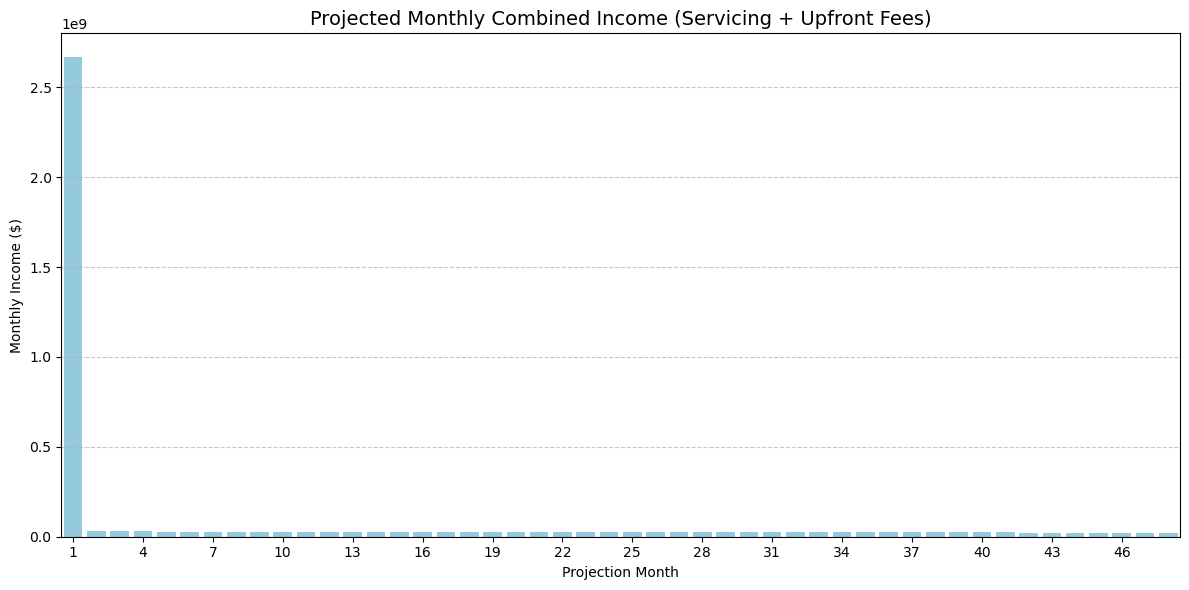

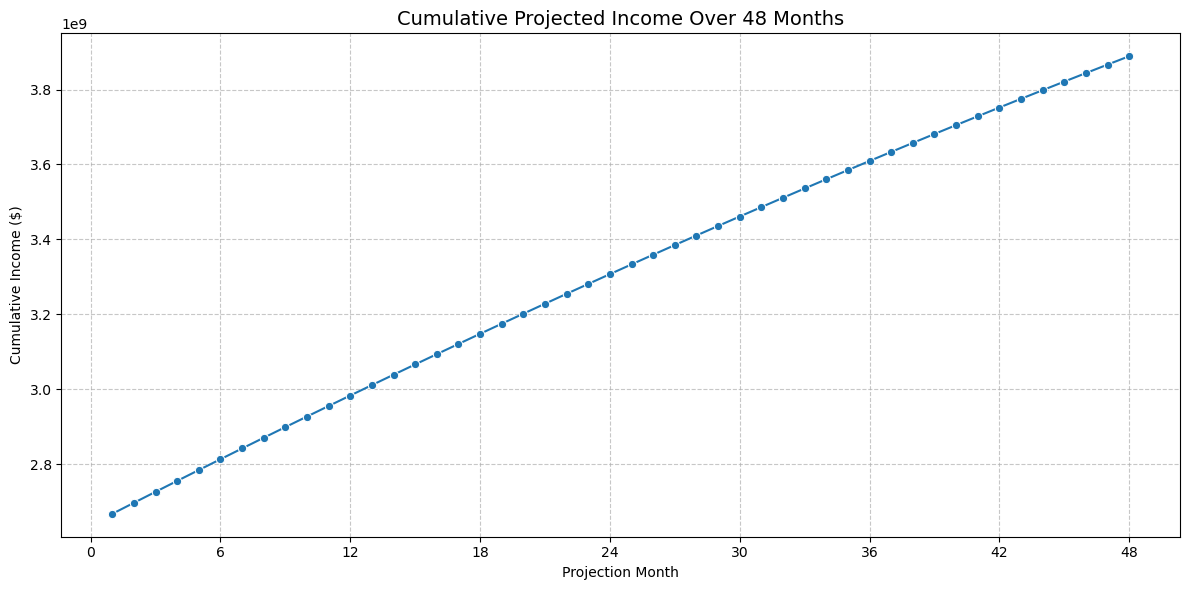

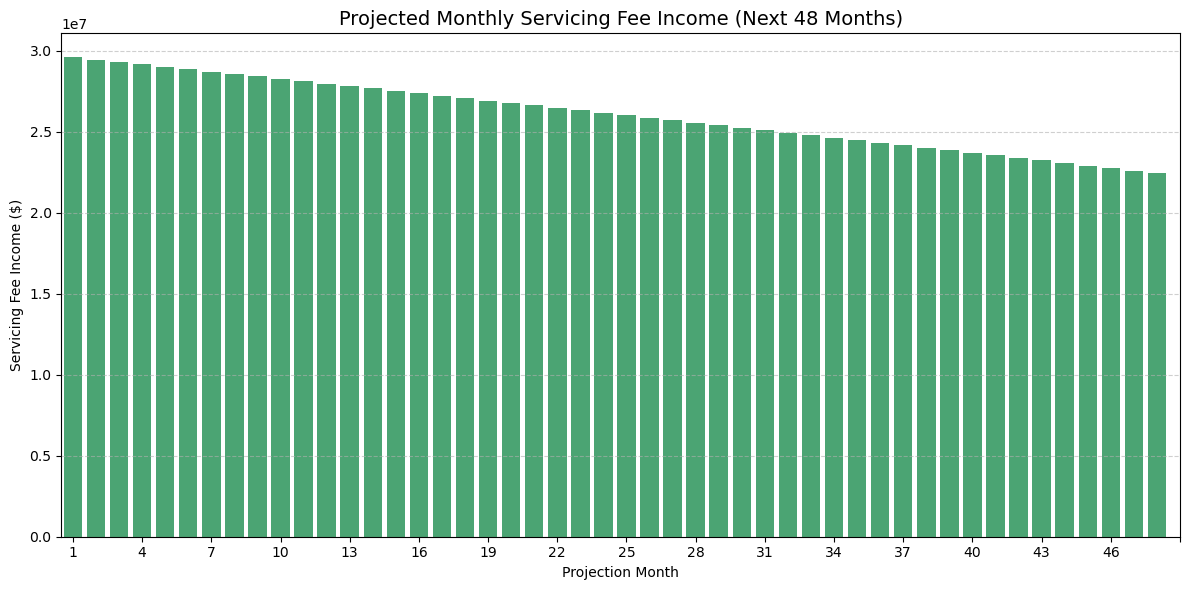

In [42]:
plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_combined_income.index, y=monthly_combined_income.values, color="skyblue")
plt.title('Projected Monthly Combined Income (Servicing + Upfront Fees)', fontsize=14)
plt.xlabel('Projection Month')
plt.ylabel('Monthly Income ($)')
plt.xticks(ticks=range(0, PROJECTION_MONTHS, 3))  # Label every 3rd month
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Cumulative income
cumulative_income = monthly_combined_income.cumsum()

plt.figure(figsize=(12, 6))
sns.lineplot(x=cumulative_income.index, y=cumulative_income.values, marker='o')
plt.title('Cumulative Projected Income Over 48 Months', fontsize=14)
plt.xlabel('Projection Month')
plt.ylabel('Cumulative Income ($)')
plt.xticks(ticks=range(0, PROJECTION_MONTHS + 1, 6))
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Summarize only the servicing portion
monthly_servicing_income = projected_df.groupby('ProjectionMonthOffset')['ProjectedMonthlyFee'].sum()

# Plot the projected monthly servicing income
plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_servicing_income.index, y=monthly_servicing_income.values, color="mediumseagreen")
plt.title('Projected Monthly Servicing Fee Income (Next 48 Months)', fontsize=14)
plt.xlabel('Projection Month')
plt.ylabel('Servicing Fee Income ($)')
plt.xticks(ticks=range(0, PROJECTION_MONTHS + 1, 3))
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



Loss Vs Fee


--- Loss vs. Fee Comparison by Year ---
 Year  Expected_Loss  Projected_Income           Net
    1   7.357964e+08      2.983050e+09  2.247253e+09
    2   7.357964e+08      3.240468e+08 -4.117496e+08
    3   7.357964e+08      3.020977e+08 -4.336987e+08
    4   7.357964e+08      2.797036e+08 -4.560928e+08


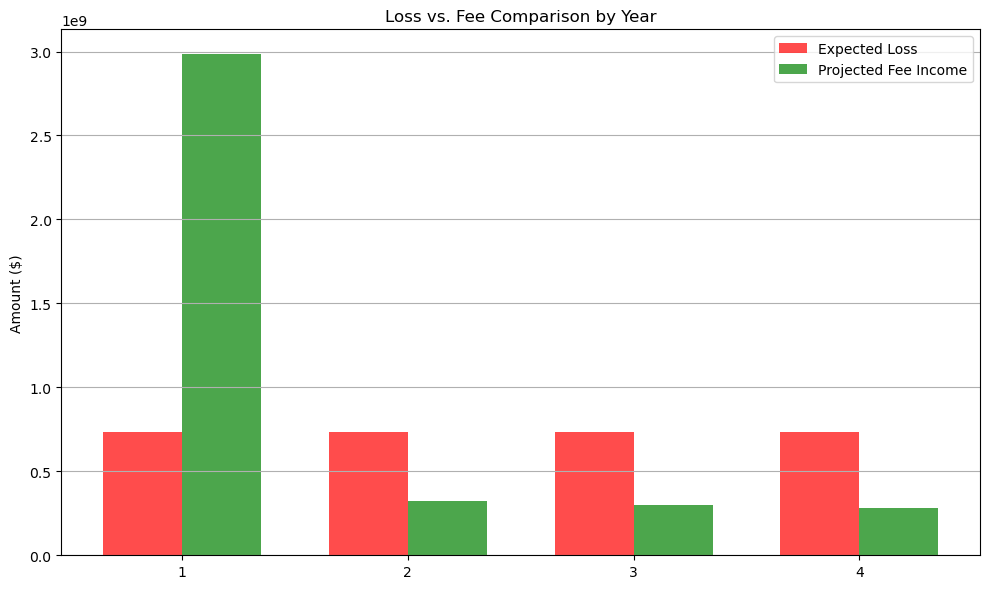


--- Loss-to-Fee Ratio by Year ---
 Year  Expected_Loss  Projected_Income  Loss_to_Fee_Ratio
    1   7.357964e+08      2.983050e+09           0.246659
    2   7.357964e+08      3.240468e+08           2.270648
    3   7.357964e+08      3.020977e+08           2.435624
    4   7.357964e+08      2.797036e+08           2.630629

Overall 4-Year Loss-to-Fee Ratio: 0.76


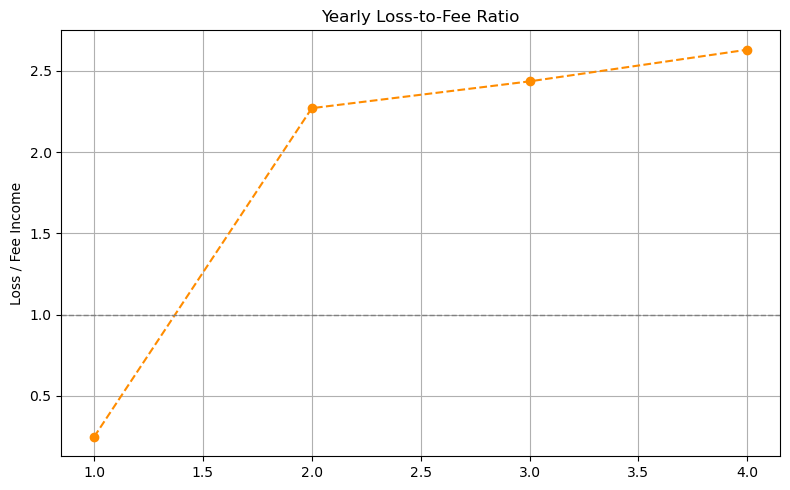

In [40]:
import pandas as pd
import numpy as np

# Assumes df_outstanding (with EL_Year_1 to EL_Year_4) and projected_df (with TotalProjectedIncome per month) already exist.

# --- Aggregate expected loss by year ---
yearly_el_df = pd.DataFrame({
    'Year': [f'Year {i}' for i in range(1, 5)],
    'Expected_Loss': [df_outstanding[f'EL_Year_{i}'].sum() for i in range(1, 5)]
})

# --- Aggregate projected income by year ---
projected_df['Year'] = ((projected_df['ProjectionMonthOffset'] - 1) // 12) + 1
yearly_fee_income = projected_df.groupby('Year')['TotalProjectedIncome'].sum().reset_index()
yearly_fee_income.rename(columns={'TotalProjectedIncome': 'Projected_Income'}, inplace=True)

# Ensure both 'Year' columns are of the same type
yearly_el_df['Year'] = yearly_el_df['Year'].str.extract(r'(\d+)').astype(int)
yearly_fee_income['Year'] = yearly_fee_income['Year'].astype(int)

# Now safe to merge
loss_vs_fee = pd.merge(yearly_el_df, yearly_fee_income, how='left', on='Year')

# --- Add Net Surplus/Deficit column ---
loss_vs_fee['Net'] = loss_vs_fee['Projected_Income'] - loss_vs_fee['Expected_Loss']

# --- Output the summary ---
print("\n--- Loss vs. Fee Comparison by Year ---")
print(loss_vs_fee.to_string(index=False))

# --- Optional: Plotting ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
width = 0.35
x = np.arange(len(loss_vs_fee))

plt.bar(x - width/2, loss_vs_fee['Expected_Loss'], width, label='Expected Loss', color='red', alpha=0.7)
plt.bar(x + width/2, loss_vs_fee['Projected_Income'], width, label='Projected Fee Income', color='green', alpha=0.7)

plt.xticks(x, loss_vs_fee['Year'])
plt.ylabel('Amount ($)')
plt.title('Loss vs. Fee Comparison by Year')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Avoid divide-by-zero
loss_vs_fee['Loss_to_Fee_Ratio'] = np.where(
    loss_vs_fee['Projected_Income'] > 0,
    loss_vs_fee['Expected_Loss'] / loss_vs_fee['Projected_Income'],
    np.nan
)

print("\n--- Loss-to-Fee Ratio by Year ---")
print(loss_vs_fee[['Year', 'Expected_Loss', 'Projected_Income', 'Loss_to_Fee_Ratio']].to_string(index=False))

# Total loss and income over 4 years
total_loss = loss_vs_fee['Expected_Loss'].sum()
total_income = loss_vs_fee['Projected_Income'].sum()

overall_ratio = total_loss / total_income if total_income > 0 else np.nan
print(f"\nOverall 4-Year Loss-to-Fee Ratio: {overall_ratio:.2f}")

plt.figure(figsize=(8, 5))
plt.plot(loss_vs_fee['Year'], loss_vs_fee['Loss_to_Fee_Ratio'], marker='o', linestyle='--', color='darkorange')
plt.axhline(1.0, color='gray', linestyle='--', linewidth=1)
plt.title("Yearly Loss-to-Fee Ratio")
plt.ylabel("Loss / Fee Income")
plt.grid(True)
plt.tight_layout()
plt.show()



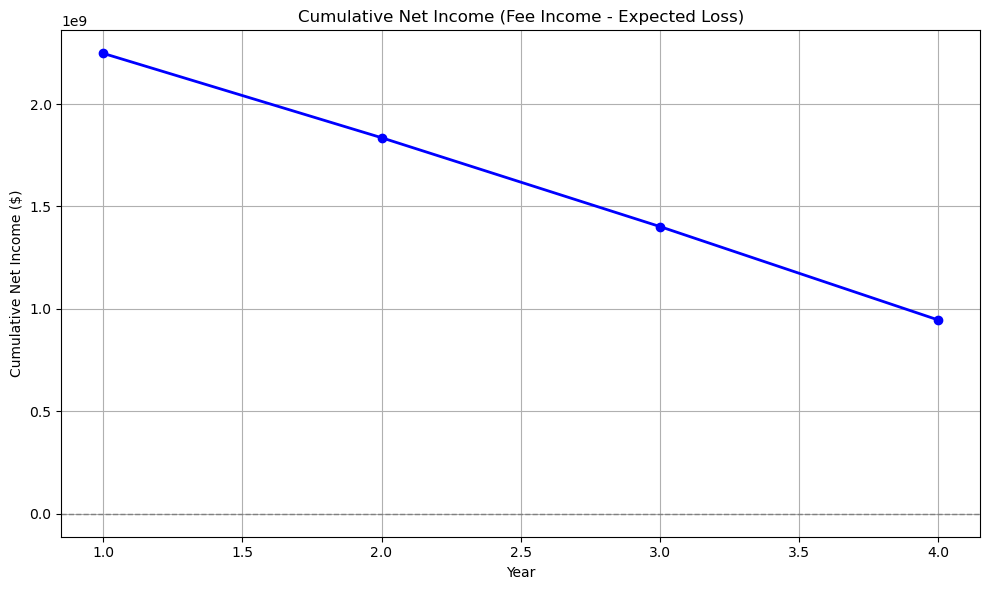

In [31]:
# --- Calculate Cumulative Net Income ---
loss_vs_fee['CumulativeNet'] = loss_vs_fee['Net'].cumsum()

# --- Plot Cumulative Net Income ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(loss_vs_fee['Year'], loss_vs_fee['CumulativeNet'], marker='o', color='blue', linewidth=2)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Cumulative Net Income (Fee Income - Expected Loss)')
plt.xlabel('Year')
plt.ylabel('Cumulative Net Income ($)')
plt.grid(True)
plt.tight_layout()
plt.show()


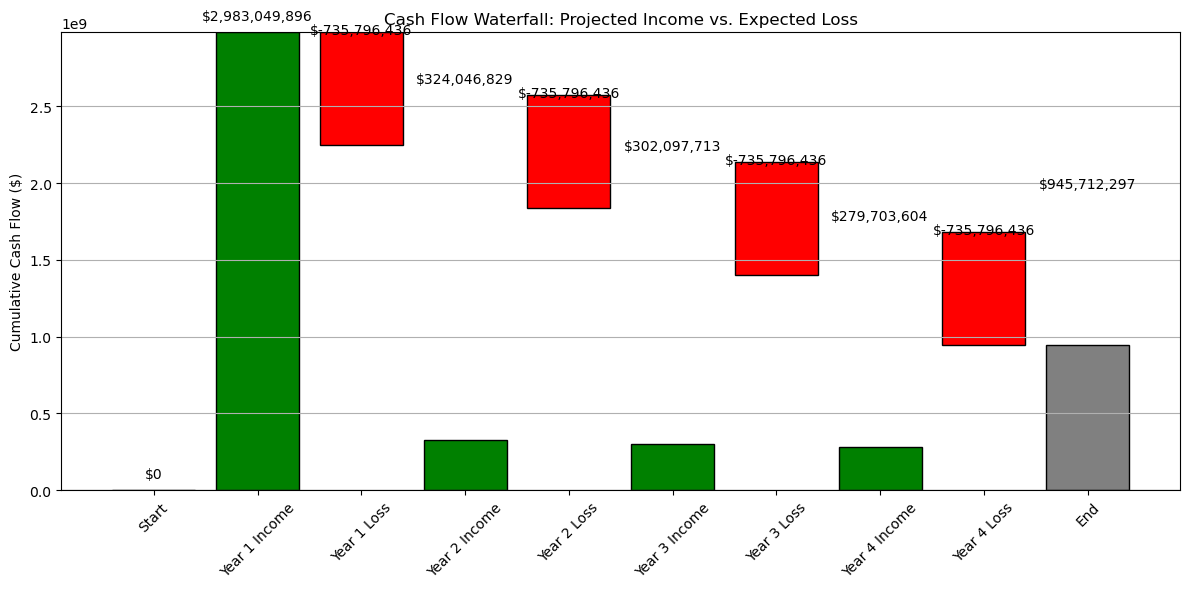

In [36]:
# --- Waterfall-style Cash Flow Chart ---

# Step 1: Create waterfall steps
waterfall_df = loss_vs_fee.copy()
waterfall_df['Label'] = 'Year ' + waterfall_df['Year'].astype(str)

# Create step-by-step cumulative cash flow
steps = [('Start', 0)]
cumulative = 0
for _, row in waterfall_df.iterrows():
    cumulative += row['Projected_Income']
    steps.append((f"{row['Label']} Income", row['Projected_Income']))
    steps.append((f"{row['Label']} Loss", -row['Expected_Loss']))

# Final balance after all years
final_balance = cumulative - loss_vs_fee['Expected_Loss'].sum()
steps.append(('End', final_balance))

# Step 2: Build DataFrame for plotting
labels, values = zip(*steps)
waterfall_plot_df = pd.DataFrame({
    'Label': labels,
    'Amount': values
})

# Compute positions for stacked bars
y = []
total = 0
for val in values:
    y.append(total)
    total += val

# Step 3: Plot the waterfall
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['gray' if 'Start' in lbl or 'End' in lbl else
          'green' if 'Income' in lbl else
          'red' for lbl in labels]

for i, (label, value, base) in enumerate(zip(labels, values, y)):
    ax.bar(label, value, bottom=base if value < 0 else 0, color=colors[i], edgecolor='black')
    ax.text(i, base + (value if value > 0 else 0) + (max(values)*0.02),
            f"${value:,.0f}", ha='center', va='bottom' if value >= 0 else 'top')

ax.set_ylabel('Cumulative Cash Flow ($)')
ax.set_title('Cash Flow Waterfall: Projected Income vs. Expected Loss')
ax.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Adverse Economic Scenarios

In [37]:
# Define economic stress scenarios
stress_scenarios = {
    'Base Case': {'PD_mult': 1.0, 'LGD_mult': 1.0},
    'Mild Recession': {'PD_mult': 1.25, 'LGD_mult': 1.1},
    'Moderate Recession': {'PD_mult': 1.5, 'LGD_mult': 1.2},
    'Severe Recession': {'PD_mult': 2.0, 'LGD_mult': 1.3}
}

# Store results
stress_results = []

for scenario, multipliers in stress_scenarios.items():
    df_stress = df_outstanding.copy()
    df_stress['Adj_PD'] = df_stress['Predicted_PD_Proba'] * multipliers['PD_mult']
    df_stress['Adj_LGD'] = df_stress['Predicted_LGD'] * multipliers['LGD_mult']
    df_stress['Adj_EL'] = df_stress['Adj_PD'].clip(upper=1.0) * df_stress['Adj_LGD'].clip(upper=1.0) * df_stress['EAD']
    
    total_adj_el = df_stress['Adj_EL'].sum()
    avg_adj_el = df_stress['Adj_EL'].mean()
    
    stress_results.append({
        'Scenario': scenario,
        'Total_Expected_Loss': total_adj_el,
        'Average_Expected_Loss': avg_adj_el
    })

# Convert to DataFrame and display
df_stress_summary = pd.DataFrame(stress_results)
print("\n--- Stress Test: Expected Loss under Economic Scenarios ---")
print(df_stress_summary.to_string(index=False))



--- Stress Test: Expected Loss under Economic Scenarios ---
          Scenario  Total_Expected_Loss  Average_Expected_Loss
         Base Case         2.943039e+09           10487.295533
    Mild Recession         3.973002e+09           14157.489961
Moderate Recession         4.892416e+09           17433.751328
  Severe Recession         6.146771e+09           21903.550488


Policy Change Impacts

In [38]:
# Define policy scenarios
policy_scenarios = {
    'Current Policy': {'guarantee_pct': 1.00, 'servicing_rate_fn': servicing_fee_rate},
    'Reduced Guarantee (75%)': {'guarantee_pct': 0.75, 'servicing_rate_fn': servicing_fee_rate},
    'Flat Servicing Fee (0.3%)': {'guarantee_pct': 1.00, 'servicing_rate_fn': lambda gross: 0.003},
    'No Upfront Fee': {'guarantee_pct': 1.00, 'servicing_rate_fn': servicing_fee_rate, 'override_upfront': 0.0}
}

policy_results = []

for name, policy in policy_scenarios.items():
    df_policy = df.copy()
    
    # Adjust guarantee amount
    df_policy['Adj_Guaranteed'] = df_policy['SBAGuaranteedApproval'] * policy['guarantee_pct']
    
    # Adjust servicing fee
    df_policy['Adj_ServicingRate'] = df_policy['GrossApproval'].apply(policy['servicing_rate_fn'])
    df_policy['Adj_AnnualFeeIncome'] = df_policy['Adj_Guaranteed'] * df_policy['Adj_ServicingRate']
    projected_annual_fee_income = df_policy['Adj_AnnualFeeIncome'].sum()
    
    # Adjust upfront fee
    if 'override_upfront' in policy:
        df_policy['Adj_UpfrontFee'] = policy['override_upfront']
    else:
        # Recompute with adjusted guarantee
        def new_upfront(row):
            gross, guaranteed, term = row['GrossApproval'], row['Adj_Guaranteed'], row['TermInMonths']
            if term <= 12:
                return 0.0 if gross <= 1_000_000 else 0.0025 * guaranteed
            else:
                if gross <= 1_000_000:
                    return 0.0
                portion_1M = min(guaranteed, 1_000_000)
                over_1M = max(guaranteed - 1_000_000, 0)
                return (0.035 * portion_1M) + (0.0375 * over_1M)
        df_policy['Adj_UpfrontFee'] = df_policy.apply(new_upfront, axis=1)
        
    total_upfront_fee = df_policy['Adj_UpfrontFee'].sum()
    total_income = total_upfront_fee + projected_annual_fee_income
    
    policy_results.append({
        'Policy_Scenario': name,
        'Projected_Annual_Servicing_Income': projected_annual_fee_income,
        'Projected_Upfront_Fee_Income': total_upfront_fee,
        'Total_Projected_Income': total_income
    })

df_policy_summary = pd.DataFrame(policy_results)
print("\n--- Policy Change Scenario Analysis ---")
print(df_policy_summary.to_string(index=False))



--- Policy Change Scenario Analysis ---
          Policy_Scenario  Projected_Annual_Servicing_Income  Projected_Upfront_Fee_Income  Total_Projected_Income
           Current Policy                       4.381402e+08                  2.637578e+09            3.075718e+09
  Reduced Guarantee (75%)                       3.286051e+08                  1.960759e+09            2.289364e+09
Flat Servicing Fee (0.3%)                       3.554630e+08                  2.637578e+09            2.993041e+09
           No Upfront Fee                       4.381402e+08                  0.000000e+00            4.381402e+08


visuals

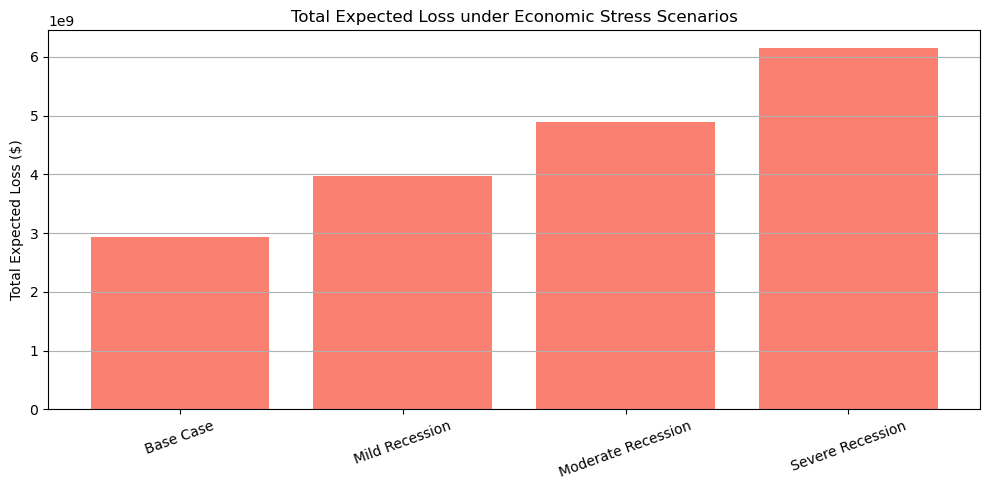

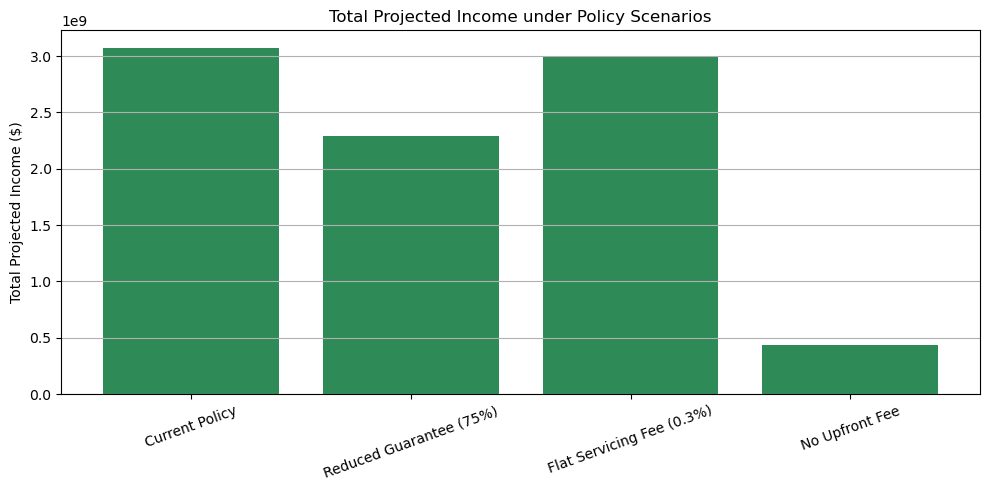

In [39]:
# Bar plot: Economic stress test
plt.figure(figsize=(10, 5))
plt.bar(df_stress_summary['Scenario'], df_stress_summary['Total_Expected_Loss'], color='salmon')
plt.title("Total Expected Loss under Economic Stress Scenarios")
plt.ylabel("Total Expected Loss ($)")
plt.grid(axis='y')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# Bar plot: Policy change impact on total income
plt.figure(figsize=(10, 5))
plt.bar(df_policy_summary['Policy_Scenario'], df_policy_summary['Total_Projected_Income'], color='seagreen')
plt.title("Total Projected Income under Policy Scenarios")
plt.ylabel("Total Projected Income ($)")
plt.grid(axis='y')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()
